In [ ]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import re
import nltk
# nltk.download('stopwords')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger","parser", "ner"])

from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec, KeyedVectors

from src.preprocess import clean_text

## Import pre-processed data

Write a function to import pre-processed data for modelling. Currently, just reading from a previously saved csv file.


In [64]:
data = pd.read_csv("data/dev_data.csv")
data['process_text'] = data['text'].apply(lambda x: clean_text(x))
# data['process_text'] = lemmatize_text(data['process_text'])

# data = pd.read_csv("data/lemmatized_dev_data.csv")

emotions = data['label'].unique().tolist()
emotions.sort()
emotions

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [65]:
# split into train and test dataset. Use only 100k samples to train and use the rest as test
X_train,X_test, y_train, y_test = train_test_split(data['process_text'], data['label'], random_state=0,
                                                   train_size= int(2e5), stratify= data['label'])

In [66]:
def preprocess(X, remove_stopwords= False):
    w2v_data = []
    for tt in X:
        if remove_stopwords:
            w2v_data.append([ww for ww in word_tokenize(tt.lower()) if ww not in stop_words])
        else:
            w2v_data.append([ww for ww in word_tokenize(tt.lower())])
    return w2v_data

In [67]:
w2v_train = preprocess(X_train, remove_stopwords= True)
w2v_test = preprocess(X_test, remove_stopwords= True)

model = Word2Vec(w2v_train, min_count = 1, window = 5, vector_size= 300)
model.wv.most_similar('affectionate')

[('hostile', 0.926654577255249),
 ('compassionate', 0.9151454567909241),
 ('considerate', 0.9051103591918945),
 ('sympathetic', 0.9047030806541443),
 ('hateful', 0.8942640423774719),
 ('unfriendly', 0.8836339116096497),
 ('submissive', 0.8797796964645386),
 ('benevolent', 0.8768906593322754),
 ('fond', 0.8729366064071655),
 ('spiteful', 0.8695470690727234)]

In [68]:
goog_wordvecs = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=100000)
print([key for key, value in goog_wordvecs.key_to_index.items() if 'affection' in key])
goog_wordvecs.most_similar('affectionate')

['affection', 'affectionate', 'affectionately', 'affections', 'affectionately_known', 'disaffection']


[('playful', 0.6595738530158997),
 ('loving', 0.6079658269882202),
 ('endearing', 0.6056519746780396),
 ('affection', 0.5745200514793396),
 ('flirtatious', 0.55764240026474),
 ('lovable', 0.5493666529655457),
 ('gentle', 0.5466917753219604),
 ('sociable', 0.5462646484375),
 ('good_natured', 0.5455296039581299),
 ('charming', 0.5257826447486877)]

In [69]:
# Create a Word2Vec Transformer
class W2VEmbeddings(TransformerMixin):
    def __init__(self, w2v_model= None, weights = None, max_len= None):
        self.w2v_model = w2v_model
        self.weights = weights
        self.word2weight = None

        # add max len parameter
        if max_len is not None:
            self.max_len = max_len
        elif self.w2v_model is not None:
            self.max_len = self.w2v_model.vector_size
        else:
            self.max_len = 100

    def fit(self, X, y=None, **fit_params):
        w2v_X = preprocess(X)

        if self.w2v_model is None:
            print(f"Fitting new Word2Vec model of size {self.max_len} on training data.")
            w2v_model = Word2Vec(w2v_X, min_count = 1, window = 5, vector_size= self.max_len)
            self.w2v_model = w2v_model.wv
            self.max_len = min(self.max_len,self.w2v_model.vector_size)
            print("Done!")
            
        if self.weights == "idf":
            tfidf = TfidfVectorizer(analyzer= lambda x: x)
            tfidf.fit(w2v_X)
            # if a word was never seen - it must be at least as infrequent as any of the known words
            # so the default idf is the max of known idf's
            max_idf = max(tfidf.idf_)
            self.word2weight = defaultdict(
                lambda: max_idf,
                [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
            print("Fit the IDF Model")
        else:
            self.word2weight = defaultdict(lambda: 1)
        return self
    
    def transform(self, X, y=None, **fit_params):
        X_w2v = []
        for vv in preprocess(X):
            X_w2v.append(np.mean([self.w2v_model[w][:self.max_len] * self.word2weight[w] for w in vv 
                    if w in self.w2v_model.key_to_index.keys()] 
                    or [np.zeros(self.max_len)], axis= 0))
        return X_w2v


Fit the IDF Model
Fit the IDF Model


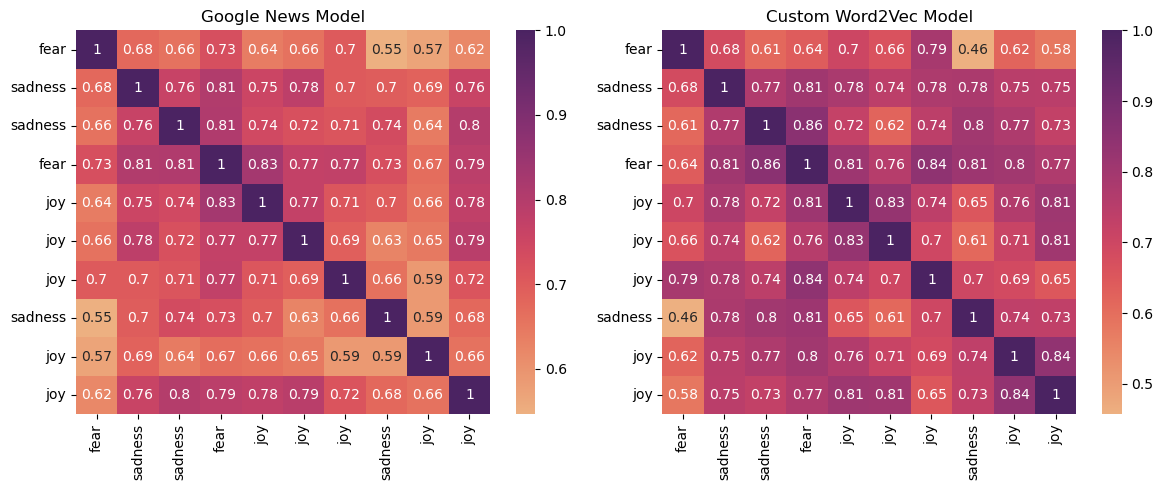

In [70]:
fig,axs = plt.subplots(figsize= (12,5), ncols= 2)

test_goog = W2VEmbeddings(weights= 'idf', w2v_model= goog_wordvecs, max_len= 300).fit_transform(X_train[:10])
sns.heatmap(pd.DataFrame(cosine_similarity(test_goog), index = y_train[:10], columns= y_train[:10]), annot= True,
            cmap= sns.color_palette("flare", as_cmap=True), ax= axs[0])
axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].set_title("Google News Model")

test_custom = W2VEmbeddings(weights= 'idf', w2v_model= model.wv, max_len= 300).fit_transform(X_train[:10])
sns.heatmap(pd.DataFrame(cosine_similarity(test_custom), index = y_train[:10], columns= y_train[:10]), annot= True,
            cmap= sns.color_palette("flare", as_cmap=True), ax= axs[1])
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].set_title("Custom Word2Vec Model")

plt.tight_layout();



In [71]:
pipe_logreg = Pipeline([
    ('w2v', W2VEmbeddings(weights= 'idf', w2v_model= goog_wordvecs, max_len= 300)),
    ('svc', OneVsRestClassifier(LogisticRegression()))
])
%time pipe_logreg.fit(X_train, y_train)
%time y_pred = pipe_logreg.predict(X_test)

print(f"Logistic Regression accuracy is: {accuracy_score(y_test, y_pred):0.2f}.\n")
print(classification_report(y_test, y_pred))

Fit the IDF Model
CPU times: total: 56.5 s
Wall time: 1min 7s
CPU times: total: 8.48 s
Wall time: 26.6 s
Logistic Regression accuracy is: 0.68.

              precision    recall  f1-score   support

       anger       0.68      0.56      0.62     18484
        fear       0.70      0.54      0.61     15673
         joy       0.69      0.84      0.76     44752
        love       0.63      0.33      0.44     10839
     sadness       0.68      0.76      0.72     38486
    surprise       0.66      0.38      0.48      4699

    accuracy                           0.68    132933
   macro avg       0.67      0.57      0.60    132933
weighted avg       0.68      0.68      0.67    132933



In [134]:
pipe_svm = Pipeline([
    ('w2v', W2VEmbeddings(weights= 'idf', w2v_model= goog_wordvecs, max_len= 300)),
    ('svc', SGDClassifier(loss= 'hinge', penalty= 'l2', max_iter= 100))
])
%time pipe_svm.fit(X_train, y_train)
%time y_pred = pipe_svm.predict(X_test)

print(f"SVM accuracy is: {accuracy_score(y_test, y_pred):0.2f}.\n")
print(classification_report(y_test, y_pred))

Fit the IDF Model
CPU times: total: 21.9 s
Wall time: 1min 41s
CPU times: total: 10.5 s
Wall time: 29.3 s
SVM accuracy is: 0.67.

              precision    recall  f1-score   support

       anger       0.70      0.53      0.61     18484
        fear       0.71      0.52      0.60     15673
         joy       0.65      0.87      0.75     44752
        love       0.62      0.25      0.36     10839
     sadness       0.69      0.74      0.71     38486
    surprise       0.68      0.29      0.41      4699

    accuracy                           0.67    132933
   macro avg       0.68      0.53      0.57    132933
weighted avg       0.67      0.67      0.66    132933



In [120]:
pipe_svm_custom = Pipeline([
    ('w2v', W2VEmbeddings(weights= 'idf', w2v_model= model.wv, max_len= 300)),
    ('svc', SGDClassifier(loss= 'hinge', penalty= 'l2'))
])
%time pipe_svm_custom.fit(X_train, y_train)
%time y_pred_custom = pipe_svm_custom.predict(X_test)

print(f"SVM accuracy is: {accuracy_score(y_test, y_pred_custom):0.2f}.\n")
print(classification_report(y_test, y_pred_custom))

Fit the IDF Model
CPU times: total: 1min 9s
Wall time: 1min 22s
CPU times: total: 15.2 s
Wall time: 16.9 s
SVM accuracy is: 0.64.

              precision    recall  f1-score   support

       anger       0.77      0.39      0.51     18484
        fear       0.63      0.50      0.56     15673
         joy       0.60      0.94      0.73     44752
        love       0.53      0.25      0.34     10839
     sadness       0.70      0.67      0.69     38486
    surprise       0.80      0.04      0.07      4699

    accuracy                           0.64    132933
   macro avg       0.67      0.46      0.48    132933
weighted avg       0.66      0.64      0.61    132933



Text(0.5, 1.0, 'Using custom Word2Vec Model')

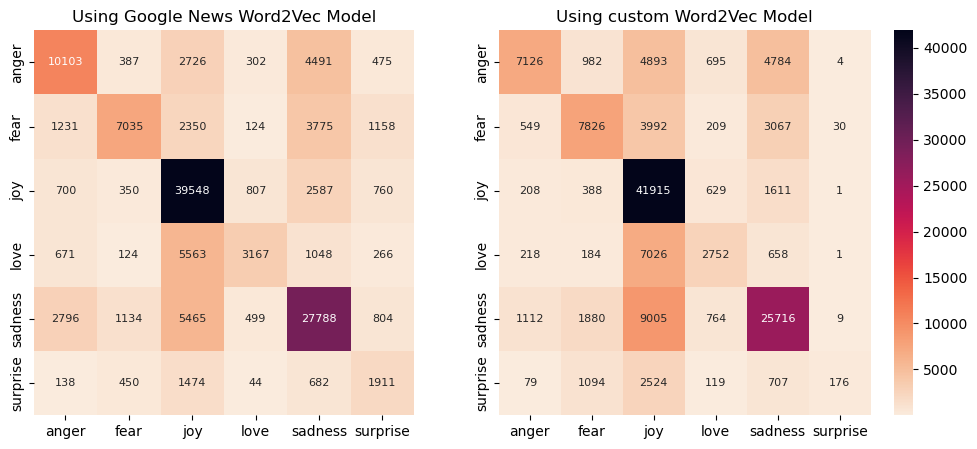

In [121]:
fig,axs = plt.subplots(figsize= (12,5), ncols= 2, width_ratios= [0.45, 0.55])

sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred), index= emotions, columns= emotions), annot= True, cbar= False,
            cmap= sns.color_palette("rocket_r", as_cmap=True), annot_kws={"fontsize":8}, fmt= 'g', ax= axs[0])
axs[0].set_title("Using Google News Word2Vec Model")

sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_custom), index= emotions, columns= emotions), annot= True, cbar= True,
            cmap= sns.color_palette("rocket_r", as_cmap=True), annot_kws={"fontsize":8}, fmt= 'g', ax= axs[1])
axs[1].set_title("Using custom Word2Vec Model")

# plt.tight_layout()

In [2]:
y_test_oe = label_binarize(y_test, classes= emotions)
# y_pred_oe = pipe_logreg.predict_proba(X_test)
y_pred_oe = label_binarize(y_pred_custom, classes= emotions)

NameError: name 'label_binarize' is not defined

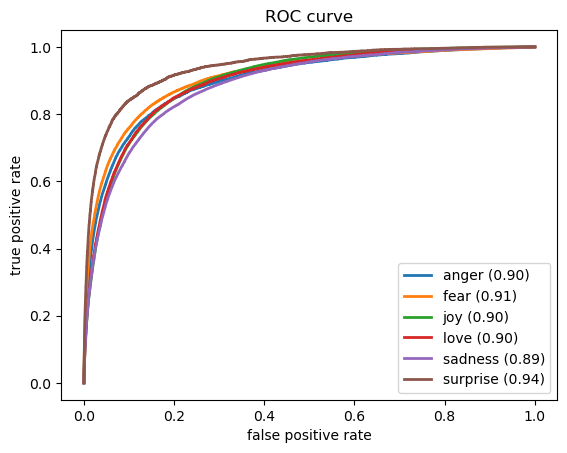

In [165]:
# roc curve
fpr = dict()
tpr = dict()

for i in range(len(emotions)):
    fpr[i], tpr[i], _ = roc_curve(y_test_oe[:, i],
                                  y_pred_oe[:, i])
    auc = roc_auc_score(y_test_oe[:, i],y_pred_oe[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label= f"{emotions[i]} ({auc:0.2f})")

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()
